## Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

## Initialize the given parameters and constants

The following general parameters are given 

* sampling frequency of the demodulated  continuous data stream, $f = 1080kHz$
* No. of range bins, $N = 30$
* Initial azimuth angle,  $\theta_{initial} = 0^\circ$ 
* Pulse Repitition Frequency: $f_r = 1800 Hz$
* Horizontal Beam Width $\theta_H = 2^\circ$
* Radar rotation speed $S = 12RPM$
* Speed of Light, $C=3\times10^{8}ms^{-1}$

Following parameters are given for the threshold detection algorithm
* Window size $W = 21$
* Guard band $G = 4$
* Standard deviation $\sigma = 1$


Following parameters are to assign values for targets detected

* no objects => 0
* Targets => 0.5
* Clouds => 1




In [ ]:
# given data

demodulated_sampling_freq = 1080*1000
range_bins = 30
initial_azimuth_angle = 0
Pulse_rep_freq = 1800
horiz_beam_width = 2
radar_rotation_speed = 12
speed_of_light = 3e8

# for threshold detection algorithm
window_size = 21
guard_band = 4
sigma = 1

# for assign values to objects detected
no_object = 0
targets = 0.5
cloud = 1

## load data files

In [ ]:
df1 = pd.read_csv('raw_data1.csv', header = None, squeeze=True)
df2 = pd.read_csv('raw_data2.csv', header = None, squeeze=True)
df3 = pd.read_csv('raw_data3.csv', header = None, squeeze=True)

Select one file to continue

In [ ]:
current_df = df3

## Downsampling

* no of samples, $n_s = 18000$

* These samples are taken at a very high sampling rate ($f$) to give the essence of a continuous signal. Therefore the first task would be to downsample these data, to fit into required range bins ($N$). The process to downsample the signal is as follows,
* First let's find out how many echo pulses are included in a given dataset.
* The total time covered by the dataset is obtained by dividing the no of samples by demodulated sampling frequency.
  >$T = \frac{n_s}{f} = \frac{18000}{1080 \times 10^3} = \frac{1}{60} s$
* Since we know the speed of the radar rotation, we can find the angle in degrees covered by the received data. 
>$\theta = \frac{S \times T \times 360^{\circ}}{60} = 1.2^{\circ}$
* Since this rotation is less than the horizontantal beam width $\theta_H$, the entire data has been received in single sweep!
*  With this data, now we can find the no of echoes received while sweeping across for  $1.2^{\circ}$. 
>no echoes, $ E = \frac{60}{N}\times \frac{1.2}{360} \times f_r = 30$ 
* $\therefore  \frac{18000}{30} = 600 \text{ samples}$ represent one echo! 
* Now we can find the sampling rate at which we should downsample this dataset to fit into $N$ range bins. 
* since $f_r$ and $N$ is given we can obtain the sampling freq to fit each echo into range bins.
> $F_s = Nf_r = 54KHz$
* Thus, downsample rate = $\frac{1080 \times 10^3}{54 \times 10^3} = 20$

* The size of the data matrix would be, $N \times E ; 30 \times 30.$


### **Assumptions**
  * Assume the data set starts from an the beginning of an echo pulse.

  * Assume the data set contains exactly the amount of data for a whole number of pulses. 





In [ ]:
no_samples = current_df.shape[0] #18000
sampling_freq = Pulse_rep_freq * range_bins #54KHz
df_sampling_rate = int(demodulated_sampling_freq/sampling_freq) #20
total_time_of_samples = no_samples/demodulated_sampling_freq #1/60
no_echoes = int(total_time_of_samples * Pulse_rep_freq) #30

raw_data = current_df[::df_sampling_rate].to_numpy().reshape(no_echoes,range_bins) #downsampling
raw_data.shape

(30, 30)

visualize the initial data matrix

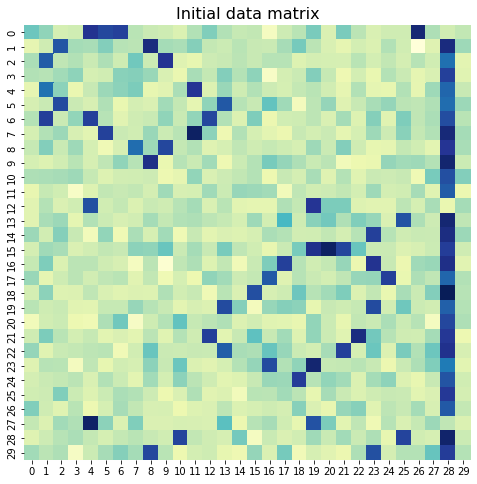

In [ ]:
plt.figure(figsize=(8,8))
plt.title(label = "Initial data matrix", fontsize = 16)

sns.heatmap(raw_data, cbar=False, cmap="YlGnBu")

## CFAR Threshold detection

To implement the threshold detection, I followed the same steps which were discussed in the lecture. Process is described below,

Noise average $(V_n)_{avg}$ for a sample range slot can be obtained as:

>$(V_n)_{avg} = \frac{\sum_{i=j+1}^{m} (\text{past video}) + \sum_{i=-j-1}^{-m} (\text{future video})}{\text {no of samples excluding guard bands}}$

Thresold value for a sample range slot is defined as :

>$V_{th}=(V_n)_{avg}+k\cdot \sigma $


* set a pre defined $k$
* extract the future data samples from original data sample
* extract the past data samples from original data sample
> since first data sample doesn't have past data samples, to make calculations easier, future data is stacked into the past data array. This won't affect the noise value as the mean would not deviate. 

### **Assumptions**
* Assume the data is fed into an FIFO memory so that past data sample for the first range bin data for current echo is obtained from the last range bin data of the previous echo.
* There is no missing values in the data stream


In [ ]:
selected_k = 2.3

reshaped_df = current_df.to_numpy().reshape(-1, df_sampling_rate) # reshaped the data matrix
size_of_sidelobe = (window_size - 1 - guard_band*2)//2

future_video = reshaped_df[:, 1+guard_band: 1+guard_band+size_of_sidelobe]
past_video = np.vstack([future_video[0], reshaped_df[:-1, df_sampling_rate-size_of_sidelobe-guard_band: df_sampling_rate-guard_band]])

v_noise_avg = (np.sum(past_video, axis = 1) + np.sum(future_video, axis = 1))/(2*size_of_sidelobe) # noise average

v_noise_th = (v_noise_avg + selected_k*sigma).reshape(no_echoes,range_bins) # noise threshold

visualize the data matrix after applying the noise threshold algorithm

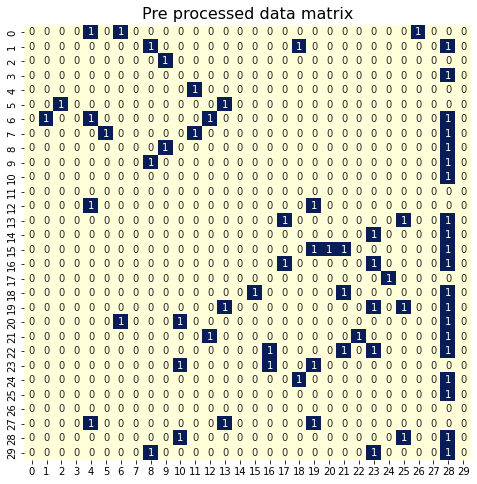

In [ ]:
pre_processed_data = (raw_data>v_noise_th).astype(float)

plt.figure(figsize=(8,8))
plt.title(label = "Pre processed data matrix", fontsize = 16)
 
sns.heatmap(pre_processed_data, cbar=False, annot=True, cmap="YlGnBu")

### Remarks
* As visible in the above heatmap, now noise has been largely filtered out. 
* But at the same time, parts of the cloud is also filtered out. 
* We can now detect the targets identified above using a simpe binary threshold. 

## Target Detection

Using Non-coherent Binary Integration, a simple algorithm is used to find the static targets in the sky. However, this target could be any object including undesirable large clutter. 

* if we find a target in the same range bin for more than half of the pulse echoes, then it is possible that there is an object. This is obtained below. 
> $ Count >= \frac{1}{2} \text{. echoes per target per sweep} $

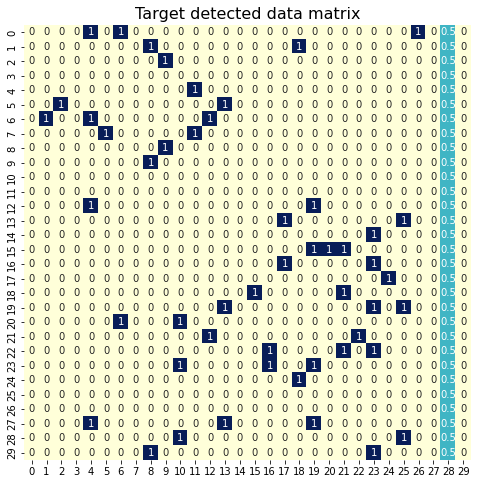

In [ ]:
expected_echoes_per_target = no_echoes/2

detected_objects = np.sum(pre_processed_data, axis=0)>=expected_echoes_per_target # detecting objects

# finding object range for angle detection - (n, m)
object_range = np.zeros([range_bins, 2])
for i in range(range_bins): 
  if (detected_objects[i]):
    arr = np.where(pre_processed_data[:,i]==1)[0]
    n = arr[0]
    m = arr[-1]
    object_range[i] = n, m

pre_processed_data[:, detected_objects] = targets # replace detected objects by target values
plt.figure(figsize=(8,8))
plt.title(label = "Target detected data matrix", fontsize = 16)

sns.heatmap(pre_processed_data, cbar=False, annot=True, cmap="YlGnBu")

visualize the data matrix after detecting static objects 

### Distance and Angle Detection

* Now we can find the distance and the azimuth angle of the targets which are detected. 
* The distance can be found by using the below formula,
> $ distance = \frac{C}{2 \times f_r} \times \frac{\text{detected range bin}}{N} m$

* Azimuth angle can be calculated as follows,
  * n = initial detected pulse
  * m = end detected pulse
  * $ azimuth\_angle = [n+\frac{m-n}{2}] \times \frac{S \times 360}{60 \times f_r} $

* Assumptions on azimuth angle
  * initial azimuth angle is zero
  * assume that the target is detected between pulse 0 to pulse 30.
  * Since the horizontal beam is $2^{\circ}$, the targets are detected even without the rotation of the radar system. So I can also argue that the azimuth angle is zero or close to zero.



In [ ]:
if not detected_objects.any():
  print ("No target detected")
for i in range(range_bins):
  if (detected_objects[i]):
    distance = (speed_of_light * (i+1))/(2*Pulse_rep_freq*range_bins * 1000) # distance
    n, m = object_range[i]
    azimuth_angle = ((n + (m-n)/2) *radar_rotation_speed * 360) / (2* 60 * Pulse_rep_freq) # azimuth angle
    print(f' A target is detected at {distance:.3f}km with an angle of {azimuth_angle:.2f} deg') # )

 A target is detected at 80.556km with an angle of 0.30 deg


Once we remove the detected targets we will be left with some noise data which comes from cloud and other dynamic clutters and random noise. 

## Cloud Detection

### Basic Noise Filtering

I found it a bit difficult to find a middle point in noise threshold algorithm which will help to detect the clouds due to following reasons. 
* When K is large, effective parts of the cloud getting filtered out
* When K is small, there are more unwanted noises to process and filter out. 

Therefore I used a simple trial and error binary thresholding algorithm which was much effective in terms of noise filtering and cloud filtering. 

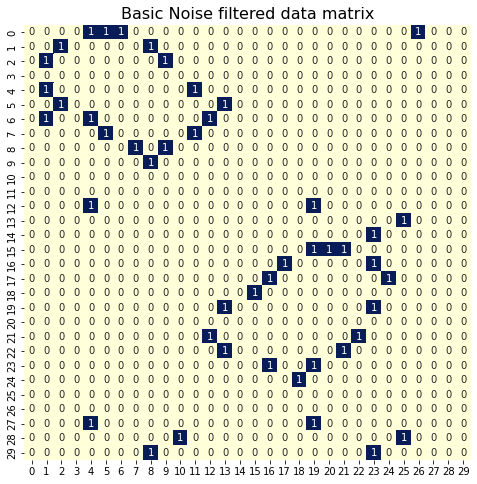

In [ ]:
binary_th = 5
pre_processed_cloud_data = (raw_data>binary_th).astype(float) # binary threshold
pre_processed_cloud_data [:, detected_objects] = no_object # remove targets temporarily

plt.figure(figsize=(8,8))
plt.title(label = "Basic Noise filtered data matrix", fontsize = 16)

sns.heatmap(pre_processed_cloud_data, cbar=False, annot=True, cmap="YlGnBu")

from the above heatmap it can be seen that there need to be some additional noise filtering need to be done in order to remove additional random noise. 

### Additional Noise Filtering

* In order to remove the additional noise from the radar data, I simply run a kernal all over the matrix and make a binary decision to whether drop the data or not. 

thresh_filter() function takes two additional paramters 
> offset -> kernal offset length ( if offset is 2, the kernal would be (5x5) )
> threshold -> take the sum of the kernal filter and check if that value is less than the threshold. If yes drop the data. 

* After running several kernals over multiple threshold values, the below values turned out to be the best combination to filter all the remaining noise. 


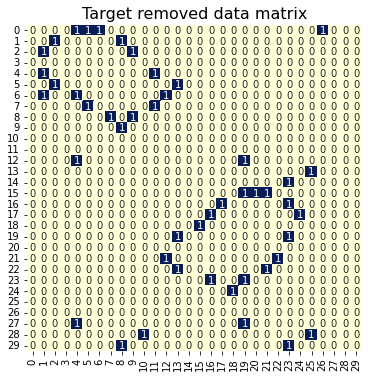

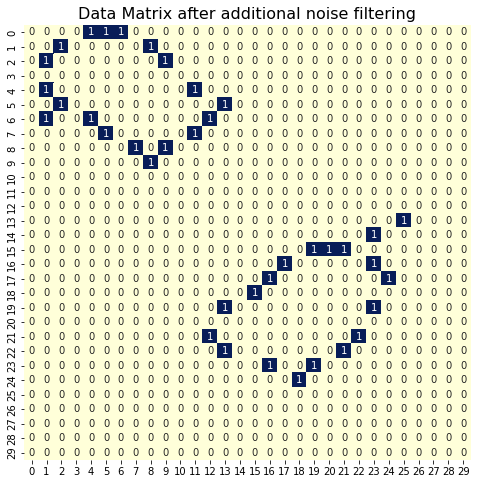

In [ ]:
def thresh_filter(matrix, offset, threshold):
  h, w = matrix.shape
  for i in range (0, h):
    for j in range(0, w):
      if (matrix[i][j]):
        # kernal creation
        li = i-offset if i>=offset else 0
        ri = i+offset if i<=w-offset else w
        uj = j-offset if j>=offset else 0
        lj = j+offset if j<=h-offset else h

        kernal = matrix[li:ri+1, uj:lj+1] 

        # consider as noise if it is lower than the predefined threshold
        if (np.sum(kernal)<threshold):
          matrix[i][j] = 0
  return matrix

plt.subplots(figsize=(6,6))
plt.title(label = "Target removed data matrix", fontsize = 16)
sns.heatmap(pre_processed_cloud_data, cbar=False, annot=True, cmap="YlGnBu")

processed_cloud_data = thresh_filter(thresh_filter(pre_processed_cloud_data, 3, 3), 2, 2) # running two kernals one after another
plt.subplots(figsize=(8,8))
plt.title('Data Matrix after additional noise filtering',fontsize = 16)
sns.heatmap(processed_cloud_data, cbar=False, annot=True, cmap="YlGnBu")

### Drawing the Cloud Contour

once the noise and the targets completely removed, in order to fill in the cloud, we have to connect the missing points in the cloud contour. For this, we may need to implement either 
* a static algorithm to connect the lines 

or
* apply an average filter as a mask

Therefore I choosed the second option as it is straightforward and can be easily configured if the mask size is not enough.


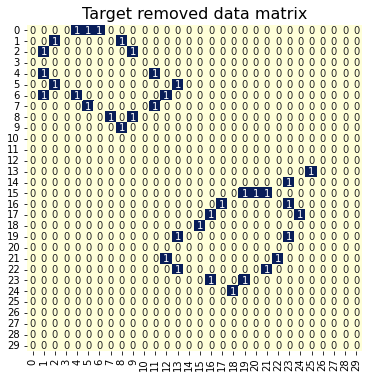

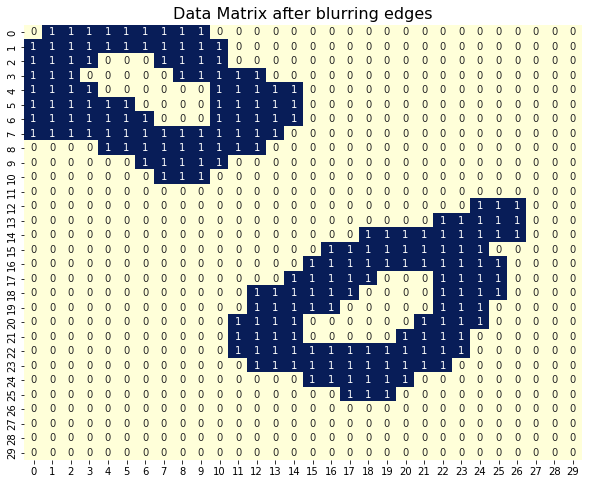

In [ ]:
def avg_filter(matrix, offset):
  h, w = matrix.shape
  output_matrix = np.zeros([h, w])
  for i in range (0, h):
    for j in range(0, w):

      # kernal creation 
      li = i-offset if i>=offset else 0
      ri = i+offset if i<=w-offset else w
      uj = j-offset if j>=offset else 0
      lj = j+offset if j<=h-offset else h
      kernal = matrix[li:ri+1, uj:lj+1] 
      output_matrix[i][j] = np.sum(kernal)/( (ri-li)* (lj-uj) )
  return output_matrix

plt.subplots(figsize=(6,6))
plt.title(label = "Target removed data matrix", fontsize = 16)
sns.heatmap(processed_cloud_data, cbar=False, annot=True, cmap="YlGnBu")

# apply avg filter and do a binary threshold
connected_cloud_data = avg_filter(processed_cloud_data, 1)
connected_cloud_data = np.where(connected_cloud_data, 1, 0)

plt.subplots(figsize=(10,8))
plt.title('Data Matrix after blurring edges',fontsize = 16)
sns.heatmap(connected_cloud_data, square=False,annot=True,cbar=False,cmap="YlGnBu") 

### Filling the Cloud Contour

as the final step of cloud detection, we need to fill in the cloud contour. Therefore for this task, there are many builtin OpenCV functions that can be used. Out of many, the popular floodfill algorithm is used with a seed point in the lower left side. 

* As the final step, the earlier detected objects were added again.




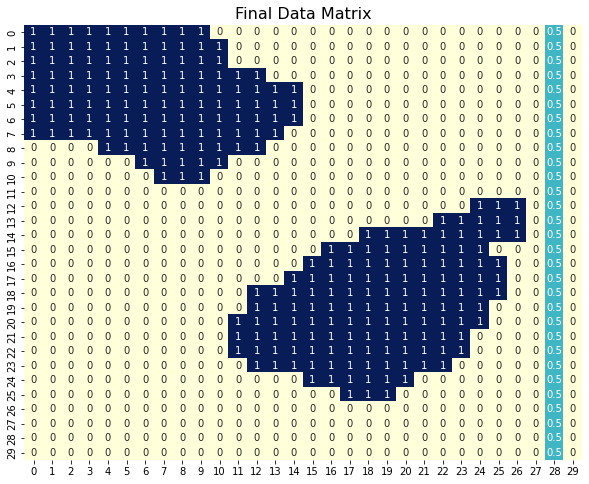

In [ ]:
connected_cloud_data = connected_cloud_data.astype(np.uint8)

# apply floodfill algorithm
floodFill=cv2.floodFill(connected_cloud_data, None, seedPoint=(29,0), newVal=2)
filled_cloud_data=floodFill[1].reshape(no_echoes,range_bins)

final_data = np.where(filled_cloud_data==2,0,1).astype(float)

# replace the detected objects
final_data[:, detected_objects] = targets

plt.figure(figsize=(10,8))
plt.title('Final Data Matrix',fontsize = 16)
sns.heatmap(final_data,annot=True,cbar=False,cmap="YlGnBu")